# pRFs!

This week we will DO pRF analysis. This will rely on a few concepts we've touched briefly on so far, and a little spoon-feeding in the realm of stimulus generation. But we will do a close approximation of all the modeling of responses done in pRF analysis in this notebook (without actually bringing real fMRI data into the picture). 

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
# The next line simply imports all the functions defined in prf_utils.py 
# (a file in this same directory) These will be useful!
import prf_utils as prf 
%matplotlib inline

# Pre-class exercises
The following cells are intended to be simple demos (and one pretty straightforward exercise) to give you a little more insight into the plotting functions that we have been and will continue to be using. If you can find time to walk through these cells before class, we are less likely to get bogged down in simple python plotting stuff, and will be able to spend more time on modeling concepts. 

This notebook makes more use of plotting functions, particularly `imshow()`, which is really useful for plotting array data such as fMRI data. If you are familiar with Matlab, this is very similar to the Matlab function `imagesc`. There are a few keyword arguments that are useful to know about this function, which are highlighted below:

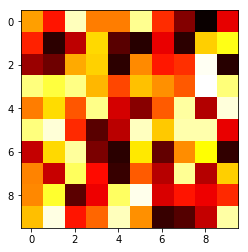

In [2]:
# Some random data
data = np.random.rand(10,10)
# show the array, with a particular color map:
plt.imshow(data, cmap='hot');
# Other colormaps can be found with the Google machine, or by doing autocomplete on the following line:
# (plt.cm is matplotlib .C.olor .M.aps)
# plt.cm. # (un-comment this, then press `tab` at the end of the line to use autocomplete.)

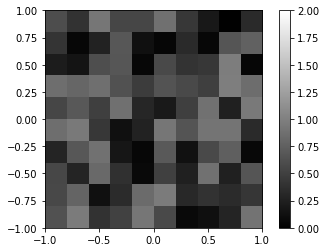

In [3]:
# The `extent` keyword defines the X and Y extents of the image data.
# vmin and vmax determine the bounds of the color scale. Here, the image will be dark, because
# the values in the array only go up to 1, but the max of the color scale (vmax) is 2
plt.imshow(data, cmap='gray', extent=[-1, 1, -1, 1], vmin=0, vmax=2)
# a color scale can be shown with plt.colorbar()
plt.colorbar();

Another very useful function is `plt.subplots`, which returns a grid of plots inside a figure, like so:

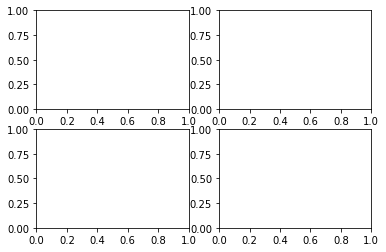

In [4]:
fig, axs = plt.subplots(2, 2)
# These can be cleaned up a little with this line (uncomment it to see the effect)
#plt.tight_layout()

The `fig` variable that this function returns is a handle to the figure (the whole shebang), and the `axs` variable is an array of handles to each individual axis. So, for example, `axs[0,0]` is the top left axis. If we wanted to plot an image of random noise in that axis, we would do the following:

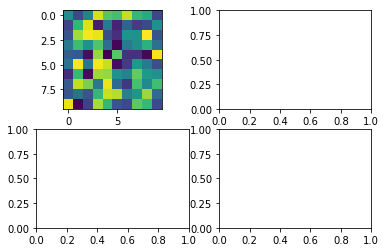

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(np.random.rand(10,10))

If you want to loop over all the axes in this subplot, it's often easier to flatten that array of axis handles. Here's how you would do that:

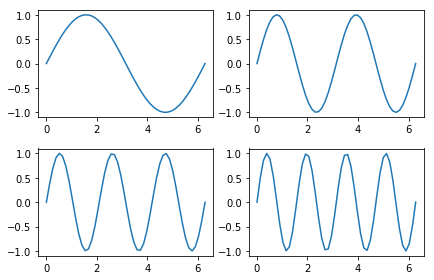

In [6]:
# Plot sine waves of different frequencies in different subplots
fig, axs = plt.subplots(2, 2)
i = 1
t = np.linspace(0, 2 * np.pi)
for ax in axs.flatten():
    # Note that here, you are using a method of the axis handle to do the plotting.
    # This works much the same way as plt.plot(), but this is actually the preferred 
    # pythonic way to make plots. plt.plot() is simple, but ends up being kludge-y 
    # in many use cases (e.g. for subplots, which are really common)
    ax.plot(t, np.sin(t*i))
    i += 1
# clean up
plt.tight_layout()

## Exercise 0
Make a plot that looks like this:
    
<img src="sinplot_4across.png",width=900>

Note that you will have to change the size of the overall figure to do this! How will you do that? (hint: use the help for `plt.subplots`!)

In [9]:
# Digression on keyword arguments
kws = dict(ncols=2)
kws

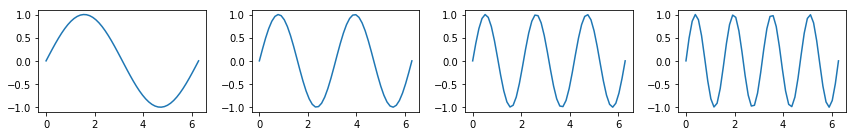

In [16]:
# Fill me in
fig, axs = plt.subplots(1, 4, figsize=(12,2))
i = 1
t = np.linspace(0, 2 * np.pi)
for ax in axs.flatten():
    # Note that here, you are using a method of the axis handle to do the plotting.
    # This works much the same way as plt.plot(), but this is actually the preferred 
    # pythonic way to make plots. plt.plot() is simple, but ends up being kludge-y 
    # in many use cases (e.g. for subplots, which are really common)
    ax.plot(t, np.sin(t*i))
    i += 1
# clean up
plt.tight_layout()

As a side note, there is a useful way to get rid of that `i+=1` part of that loop. The function `enumerate()` automatically generates an index for whatever your loop variable is, like so:

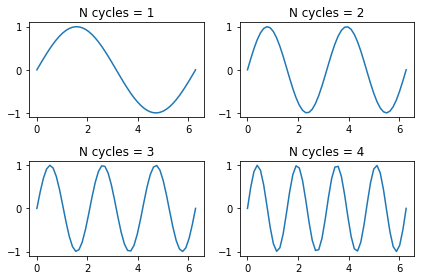

In [17]:
# Plot sine waves of different frequencies in different subplots
fig, axs = plt.subplots(2, 2)
# i = 1 # Not necessary!
t = np.linspace(0, 2 * np.pi)
# Note the syntax for enumerate here. The second argument (1) says start indexing at 1; 
# if that argument is not included, the first value of `i` will be 0
for i, ax in enumerate(axs.flatten(), 1): 
    ax.plot(t, np.sin(t*i))
    # i += 1 # Not necessary!
    # This is just here to show each value of `i` in the loop. Note python string formatting.
    ax.set_title('N cycles = %d'%i) 
# clean up
plt.tight_layout()

# Main class 
First up: pRF analysis depends on defining Gaussian receptive fields in 2D. We already generated a 2D Gaussian as a smoothing kernel; we will adapt that code here to define many potential receptive fields. Remember, the equation for a 2D Gaussian is:

# $g = e^{-\frac{(x-\mu_x)^2 + (y-\mu_y)^2}{2\sigma^2}}$

... where $\mu_x$ and $\mu_y$ are the x and y coordinates for the center of the Gaussian, and $\sigma$ is the standard deviation of the Gaussian (in this formuation, the Gaussian is circular). 

So what we have to do is evaluate this expression for a range of values for $x$ and $y$ - say, an image's worth of values. So first we must define x and y...

x min: -10.0, x max: 10.0
y min: -10.0, y max: 10.0


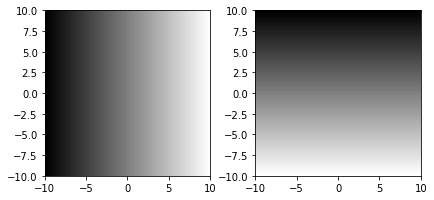

In [3]:
# Define parameters that define X, Y space (in visual degrees!)
stim_radius_degrees = 10
stim_res_pixels = 101
t = np.linspace(-stim_radius_degrees, stim_radius_degrees, stim_res_pixels)
x, y = np.meshgrid(t, t)

# Let's show what we've done here
# Here's a really useful command to return a figure and subplots within that figure:
rows = 1 # Defined here to be explicit
columns = 2 # Defined here to be explicit
fig, ax = plt.subplots(rows, columns)
# Note the use of `extent` here - extent specifies the X and Y coordinates of the 
# image as displayed! If extent is not specified, the X and Y coordinates of the plot
# are assumed to be indices for 0 to n_pixels in the image,
extent = [-stim_radius_degrees, stim_radius_degrees, -stim_radius_degrees, stim_radius_degrees]
im1 = ax[0].imshow(x, extent=extent, cmap='gray')
im2 = ax[1].imshow(y, extent=extent, cmap='gray')
print('x min: {}, x max: {}'.format(x.min(), x.max()))
print('y min: {}, y max: {}'.format(y.min(), y.max()))
plt.tight_layout()

In [4]:
x.shape

(101, 101)

## Exercise 1
Write a function to generate a Gaussian with some specific $\mu_x$, $\mu_y$, and $\sigma$

Use that function to generate a Gaussian with $\mu_x$ = 5, $\mu_y$ = 0, and $\sigma$ = 0.5

# $g = e^{-\frac{(x-\mu_x)^2 + (y-\mu_y)^2}{2\sigma^2}}$

In [5]:
# Fill me in!
def make_gauss(mu_x, mu_y, sigma, x=x, y=y):
    """Generate a 2D Gaussian function
    
    Parameters
    ----------
    mu_x : scalar
        x mean (center) of Gaussian
    mu_y : scalar
        y mean (center) of Gaussian
    sigma : scalar
        standard deviation of Gaussian
    x : array
        x value or values over which to evaluate the function
    y : array
        y value or values over which to evaluate the function
    """
    g = np.exp(-((x-mu_x)**2 + (y-mu_y)**2 ) / (2 * sigma**2)) 
    return g

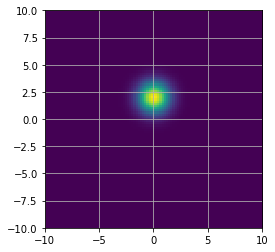

In [8]:
g = make_gauss(0, 2, 1)
fig, axs = plt.subplots()
axs.set_ylim([-10, 10])
axs.imshow(g, extent=[-10, 10, 10, -10])
axs.grid(axis='both')

In [11]:
# ... and then make a Gaussian with mu_x=5, mu_y=0, and sigma=0.5!
g = make_gauss(5, 0, 0.5)
# And display it!
# somehow?

## Exercise 2
Now, make a bunch of Gaussians! Define a grid of potential (x, y) locations and $\sigma$ values, and create an image of a Gaussian for each! store them all in a 3D array (x, y, gaussian image). This will end up being of shape (101, 101, n_gaussians) (101 is the pixel resolution for these images that we specified above)

Hint: this will probably involve a loop, or loops! There are two ways to go about creating and filling a 3D array: 

1. Generate an array of zeros first, and substitute values into it. 
2. Create a list of 2D images and use the function `np.dstack()` (remember how to get help on any function??)

In [9]:
# Fill me in!
# (Maybe do something here...?)
x_loc = np.linspace(-9, 9, 10)
y_loc = np.linspace(-9, 9, 10)
sigmas = [0.1, 0.2, 0.4, 0.8, 1.6]

g = []
xysig = []
# Loop over x values
for mu_x in x_loc:
    # Loop over y values
    for mu_y in y_loc:
        # Loop over sigma
        for sig in sigmas:
            xysig.append([mu_x, mu_y, sig])
            tmp = make_gauss(mu_x, mu_y, sig)
            # save!
            g.append(tmp)
g = np.dstack(g)
xysig = np.array(xysig)
# Finish up

In [13]:
g.shape

(101, 101, 500)

# Exercise 3
Show all the Gaussians you have created that are a particular size! i.e., all Gaussians with X=1 (or whatever), Y=1 (or whatever), and each value of sigma that you specified. Hint: If you have done this in a sensible way, then these specific Gaussians should be some regular number of indices away from each other in the 3rd dimension of your array! When you index an array, the index for each dimension goes [start:stop:step]. So, e.g., `X[:, ::2]` selects every other column of `X` (first dimension of an array is rows, second dimension is columns). 

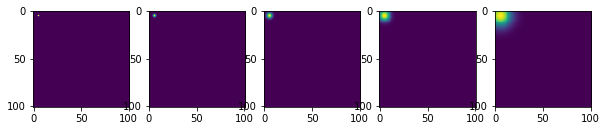

In [14]:
# hint: use subplots
fig, axs = plt.subplots(1, 5, figsize=(10, 2)) # ... how many?
for i, ax in enumerate(axs.flatten()):
    ax.imshow(g[:, :, i])
# Show a different Gaussian in each subplot...

# Exercise 4: Make stimuli! 
The next step (or, a parallel step) in pRF analysis is to create a contrast image for your stimulus. The way that this was done is not specified in the paper, because this is fairly straightforward to figure out, if you think carefully about it! 

Most of this code will be provided for you, but I want to give you a taste of how it is done. So first, let's create a circle of radius 10 over the grid of X, Y values we already have. That is, we want an image for which every value inside the circle is 1, and every value outside of it is 0, like this: 

<img src="circle_image.png",width=300,height=300>

A filled circle can be defined over a range of X and Y values by:
1. computing the distance from a fixed point in the X, Y plane (0, 0 is a good one!)
    Distance (Euclidean distance) is computed by the Pythagorean theorm: $d = \sqrt{(x-x0)^2 + (y-y0)^2}$
2. using an inequality to select all points less than some distance (the radius of the circle) from the fixed point
    i.e., d < 10
    (if this is done for a whole array of values, then the values for the array all evaluate to `True` or `False` - which can be converted to 1s and 0s!

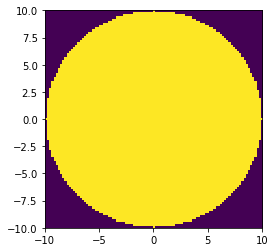

In [16]:
# Fill me in!
# Define distance from the point 0, 0:
d = np.sqrt(x**2 + y**2)
#plt.imshow(d)
#plt.colorbar()
circle = d <= 10 # ...?
# to convert True / False values to 0 and 1, just use: 
circle = circle.astype(np.float)
# And then show the result!
plt.imshow(circle, extent=extent);

# For our next trick, we will create a bar stimulus inside that circle!
This part we will just do as a demo; too much complexity for 1 hour

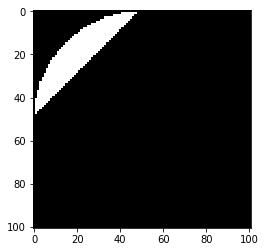

In [17]:
# Define bar parameters (modify these to see how it changes the plot!)
orientation = np.radians(45) # 45 degrees
width = 5
phase = 0.01 # 0-1
# Define sampling of visual space
t = np.linspace(-stim_radius_degrees, stim_radius_degrees, stim_res_pixels)
# Define grid sampling X and Y space
xg, yg = np.meshgrid(t, t)
# Make a circle as above
r = np.sqrt(xg**2 + yg**2)
full_area = r < stim_radius_degrees
# Scale X and Y gradients to tip line of inequality below
xg *= np.sin(orientation)
yg *= np.cos(orientation)
# Define two separate inequalities
p1 = stim_radius_degrees * 2 * phase + -stim_radius_degrees - width / 2.0
p2 = stim_radius_degrees * 2 * phase + -stim_radius_degrees + width / 2.0
# Double inequality selects a bar of space
bar = ((xg+yg) >= p1) & ((xg+yg) <= p2)
# Couple that with the original circle, and you've got a bar!
mask = bar & full_area
mask = mask.astype(np.float)
plt.imshow(mask, cmap='gray');

Code to create bars like this in a sequence of frames is already in the prf_utils.py function (you can have a look at the code there if you're curious!). For now, we will simply use the following function to define a bunch of bars moving across the visual field.

In [21]:
# Create a whole array of bar stimuli in different positions
bars = prf.make_bar_sequence()
# Size is pixels_x x pixels_y x time
print(bars.shape)
# The last dimension is the number of TRs in this experiment. 
n_trs = bars.shape[-1]

(101, 101, 128)


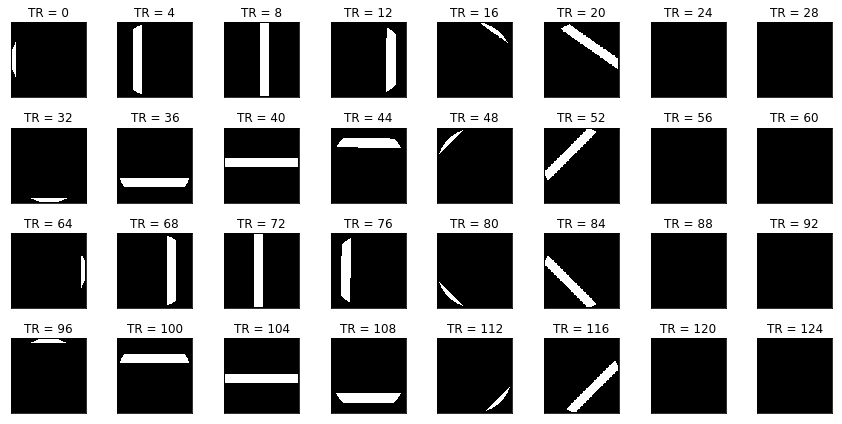

In [22]:
# The sequence of bars over frames (TRs) follows a similar pattern to the bars in the Dumoulin paper
fig, axs = plt.subplots(4, 8, figsize=(12,6))
i = 0
for ax in axs.flatten():
    ax.imshow(bars[:, :, i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('TR = %d'%i)
    i += 4
plt.tight_layout()

SO! In pRF analysis, we want to predict the response to each of these bar stimuli (i.e., the response to each frame), for each potential pRF (for each different Gaussian in our list of Gaussians). 

To predict the response for a single frame for a single Gaussian, you simply multiply the two images together, and sum over all pixels. So: Do it! 

## Exercise 5: predict a response!
For this exercise, we will define a specific gaussian and a specific bar.

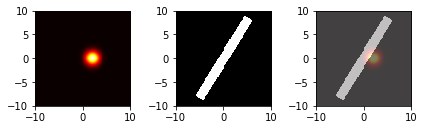

In [23]:
g_ex5 = make_gauss(2, 0, 1)
bar_ex5 = prf.make_bar_im(2, 45, 0.5)
fig, axs = plt.subplots(1, 3)
# Show Gaussian
axs[0].imshow(g_ex5, cmap='hot', extent=extent)
# Show bar
axs[1].imshow(bar_ex5, cmap='gray', extent=extent)
# Show image overlap of bar on top of Gaussian
axs[2].imshow(g_ex5, alpha=0.5, cmap='hot', extent=extent)
axs[2].imshow(bar_ex5, alpha=0.5, cmap='gray', extent=extent)
# Clean things up
plt.tight_layout()

37.386320912817034


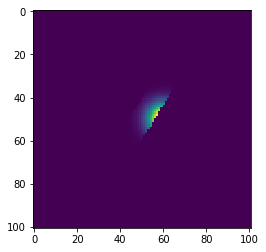

In [24]:
# So...
tmp = g_ex5 * bar_ex5
plt.imshow(tmp)
resp_ex5 = np.sum(tmp)  # ? WHAT will the response be? (this should be a single number!)
print(resp_ex5)

The next cells reveal the answer to the above exercise, so please stop scrolling till you're done...

No seriously. Do the exercise first. It's not too bad.

So! Here's a sneaky trick you may not have realized. You don't necessarily have to keep the images in image form, if you are just multiplying pixels by pixels and then summing everything up. You can do either of the following:

In [25]:
# Simple sum
resp_ex5 = np.sum(g_ex5 * bar_ex5)
# Matrix dot product (Same operation!)
g_ex5_ = g_ex5.reshape(stim_res_pixels**2, 1)
bar_ex5_ = bar_ex5.reshape(stim_res_pixels**2, 1)
resp_ex5_ = bar_ex5_.T.dot(g_ex5_)

In [26]:
# Same same!
print(resp_ex5_) # well, this is in an array, but the value is the same.
print(resp_ex5)

[[37.38632091]]
37.386320912817034


# Blackboard talk
... The upshot of all this is that we can quickly compute *all* of the responses using a single matrix operation, if we reshape the arrays containing the bar stimuli and the Gaussians first:

In [27]:
# Reshape arrays for stimuli & Gaussians
stim = bars.reshape(stim_res_pixels**2, -1).T
# The result is of shape (time x all pixels)
print(stim.shape)
gr = g.reshape(stim_res_pixels**2, -1)
# The result here is of shape (all pixels x Specific Gaussian)
print(gr.shape)

(128, 10201)
(10201, 500)


Now, this matrix dot product yields an array that is time x Gaussians; i.e., each column is a prediction of a response for one of the Gaussian pRFs over the timecourse of the bar stimuli.

In [29]:
# Compute *all* predictions
p_raw = stim.dot(gr) # So simple!
print(p_raw.shape)

(128, 500)


# Fancy animated plot
to show what we've done

In [30]:
from IPython.display import HTML
def make_fancy_anim(idx, resp=p_raw, prfims=g, stim=bars, interval=80, normalize_response=True, extent=extent):
    """This just sets some defaults for the prf function based on stuff above in this notebook"""
    return prf.make_fancy_anim(idx, resp=resp, prf=prfims, stim=stim, interval=interval, 
                               normalize_response=normalize_response, extent=extent)

In [27]:
# The next line is a little fancy. Don't worry about this too much, you can just
# pick a random index from 0 to 1350 and see what it does.
index, = np.where((xysig == (x_loc[5], y_loc[5], sigmas[4])).all(axis=1))[0]
# Or, e.g.:
# index = 122
anim = make_fancy_anim(index, resp=p_raw, normalize_response=True)
HTML(anim.to_html5_video())

In [28]:
p_raw.shape

(128, 500)

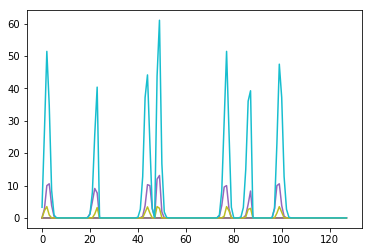

In [29]:
plt.plot(p_raw[:, :10])

Stopped here in class! Please do continue on your own.

# Exercise 6
Each column of `p` needs to be convolved with the HRF function to make a real prediction of fMRI responses. You have already seen how to do a 1D convolution using `np.convolve`; now, try doing it in a loop, modifying each column of p! As with the array of Gaussians above, this can be done one of two ways: by pre-allocating an array, or by collecting results in a list and creating an array from that list at the end. When you are done, plot a single column of `p`, and in the same plot, plot the HRF-convolved version of the same column.

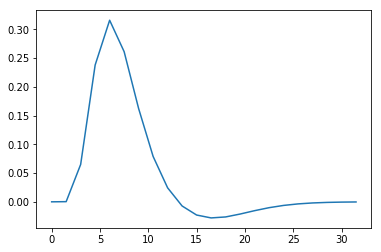

In [16]:
# Get a fancy two-gamma HRF
t_hrf, hrf = prf.make_hrf(tr=1.5)
plt.plot(t_hrf, hrf);

In [ ]:
# Fill me in!
p_hrf = [] # ? 

In [31]:
# Show the convolved HRF plot in our fancy animation:
index, = np.where((xysig == (x_loc[5], y_loc[9], sigmas[3])).all(axis=1))[0]
anim = make_fancy_anim(index, resp=p_hrf, normalize_response=True)
HTML(anim.to_html5_video())

NameError: name 'p_hrf' is not defined

As a last side note, there is another useful function for doing convolution: `scipy.ndimage.convolve1d()`. This function allows you to specify an axis along which to convolve the data (here, the 0th axis, aka the first or vertical axis). The syntax is a bit different than the numpy function - the specification of `mode` handles what values are assumed to be outside the timecourse of the stimulus, and the `origin` keyword argument specifies where the convolution kernel should be centered (0 is at the middle of the kernel, here the middle of the HRF; -11, here, is at the far left of the HRF (because the HRF is 22 units long, and half of 22 is 11). We specify -11 and not zero because the HRF is a DELAY in the signal, not a symmetrical filter, we want the effect of the convolution to occur AFTER events or deflections in the original stimulus model. 

This handling of where the convolution kernel is centered is an issue with any convolution function; previously, we handled this by using mode='full' and clipping only the end, not the end and the beginning, of the resulting data.

In [ ]:
from scipy.ndimage import convolve1d

In [ ]:
p_hrf2 = convolve1d(p_raw, hrf, axis=0, mode='constant', origin=-11)

# Plot to show that this gives the same result w/ more compact code:
plt.plot(p_raw[:, idx], label='original response')
plt.plot(p_hrf[:, idx], '.-', label='numpy function\n+ loop')
plt.plot(p_hrf2[:, idx], 'k.:', label='scipy function')
plt.legend(loc='best')

In [ ]:
# And just to show you what happens if you set origin to 0:
p_hrf2 = convolve1d(p_raw, hrf, axis=0, mode='constant', origin=0)

# Plot to show that this gives the same result w/ more compact code:
plt.plot(p_raw[:, idx], label='original response')
plt.plot(p_hrf[:, idx], '.-', label='numpy function\n+ loop')
plt.plot(p_hrf2[:, idx], 'k.:', label='scipy function')
plt.legend(loc='best')
# This is obviously not what you intended with the HRF (black lines resulting from scipy convolution 
# are now BEFORE stimulus eventts)

The last step in pRF analysis is to compare each of these predictions to real brain responses recorded while a subject was watching bar stimuli flicker past. We *may* get to that in subsequent weeks (or simply in a demo notebook), but for now it's beyond our scope...